In [12]:
import numpy as np       # the NumPy library for fast matrix and vector data types and math operations
import matplotlib.pyplot as plt   # functions for plotting, loaded under a convenient name alias 'plt'
from pylab import plot, show, xlabel, ylabel, legend, semilogy,semilogx, grid, xlim, ylim, title,savefig, minorticks_on, figtext,text, errorbar
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (16, 9),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
import csv
import pandas as pd
from astropy import modeling
from scipy import optimize
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from scipy.integrate import quad
import datetime
from datetime import timedelta
from datetime import datetime
from scipy.optimize import curve_fit

Some usefull constants and standard properties

In [13]:
Rgas=8.314 #J/mol/k
kB=1.38064852e-23 #m^2kg/(s^2K)
u=1.66e-27 #kg
NA=6.022140857e23 #number of atoms in a mol
eV=1.602176565e-19 #J
me=9.1093837015e-31 #kg

Material properties gallium

In [14]:
T = np.arange(273.15, 3574.15, 0.01)  # Set the surface temperature as a variable
pa=0 # Assume pressure = 0 in Magnum Gallium properties

rho_Ga=5904 #kg/m^3
k_Ga=40.6 #W/mk
cp_Ga=371 #J/kgK
Evap_Ga = 258.7e3/NA #J/mol
M_Ga=69.723e-3 #kg/mol
pv_Ga=10**(-13984/T-0.31413*np.log10(T)+11.76)

Tcool=20+273.15#C
def qmod(R, C, eps_cool):
    Gam_vap_Ga=(pv_Ga-pa)/np.sqrt(2*np.pi*M_Ga*u*kB*T)
    qcond_Ga=C*(T-Tcool)
    qplasma_Ga=qcond_Ga+Gam_vap_Ga*(1-R)*(eps_cool+Evap_Ga)
    return qplasma_Ga*1e-6


In [15]:
def gaussian(x, amplitude, mean, stddev,offset): #make a funciton that returns a gaussian
    return amplitude * np.exp(-((x - mean)/ stddev)**2/ 2)+offset

Import Thomson data

In [16]:
x=np.arange(-25,25,0.1)
shotnr=[28925,28928,28935,28939,28943,28947,28950]
def TS(expnum):
    filename=('Thomson_2021-06-10_#' + str(shotnr[expnum-1]) + '.txt')
    df = pd.read_csv(filename, delimiter = "\t", skiprows=5, warn_bad_lines=True, error_bad_lines=False) #remove lines that do not have 5 columns 
    data_columns=df.columns.values
    num_df = (df.drop(data_columns, axis=1).join(df[data_columns].apply(pd.to_numeric, errors='coerce'))) #remove the lines that are not fully numerical
    num_df = num_df[num_df[data_columns].notnull().all(axis=1)] #remove the lines that are not fully numerical
    num_df.index=list(range(0, len(num_df))) #sets the indec to start at 0 and increase by 1, row number

    # There are 3 Thomson measurements per exp so we need to see which times correspond to thebegining and end of each exp. 
    difference = num_df.diff(axis=0) #difference between two consecutive rows
    t12=num_df[difference.iloc[:,0]<0].index.values #the 1st column is the position which per measurement always increases, so if the diff is negative it means we have a new measurement 
    T1=num_df.iloc[0:t12[0]]
    T2=num_df.iloc[t12[0]:t12[1]]
    T3=num_df.iloc[t12[1]:len(num_df)]

    popt, pcov = optimize.curve_fit(gaussian, T3.iloc[:,0], T3.iloc[:,2],[3,3,1,0],bounds=((0, -np.inf,0, -np.inf),(np.inf,np.inf,np.inf, np.inf))) # Optimize for temperature, popt is: [amplitude, mean, stddev,offset]
    popt_n, pcov_n = optimize.curve_fit(gaussian, T3.iloc[:,0], (T3.iloc[:,1]*1e-19),[2,3,6,3]) # Optimize for temperature, popt is: [amplitude, mean, stddev,offset]
    return T3,popt,pcov,popt_n,pcov_n


Plot the first TS data

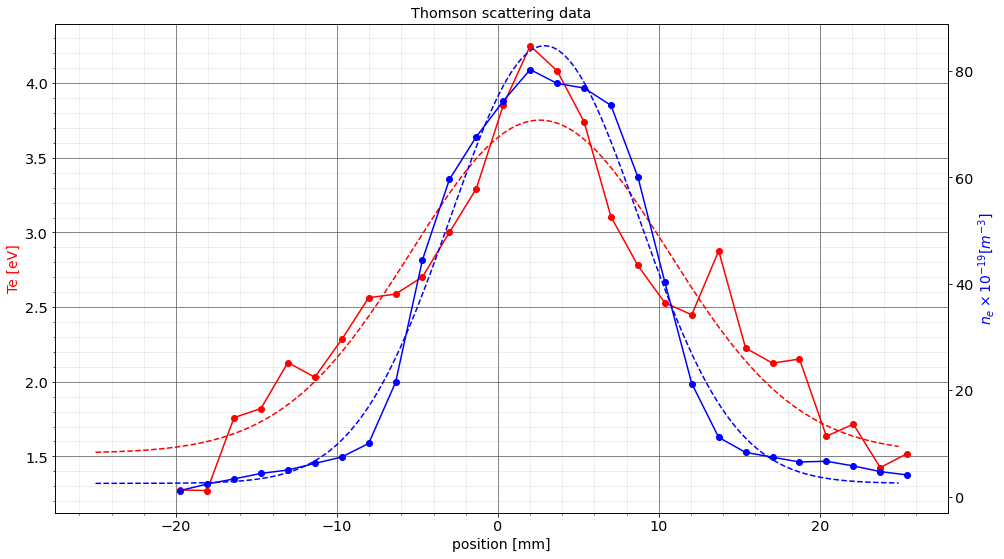

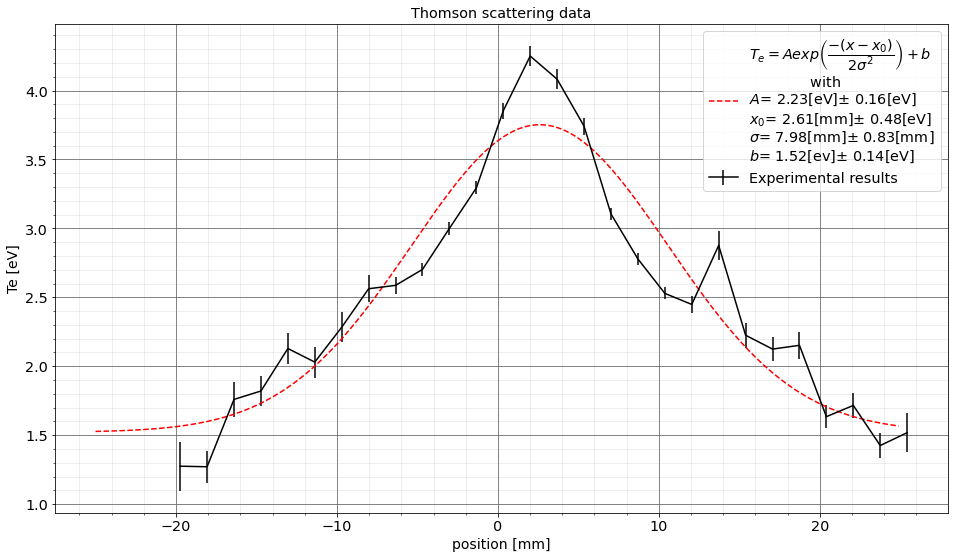

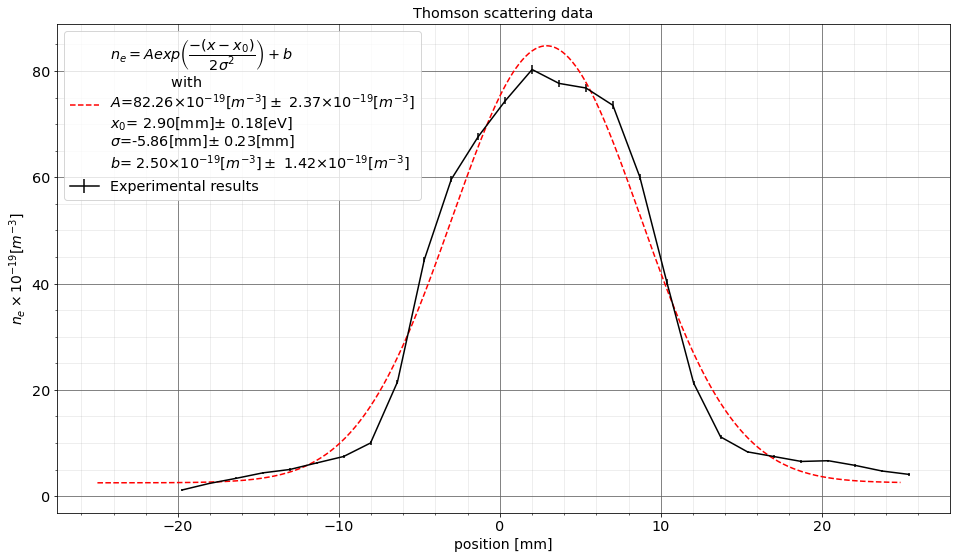

In [17]:
T3,popt,pcov,popt_n,pcov_n=TS(6)
fig,ax = plt.subplots()
ax.plot(T3.iloc[:,0],T3.iloc[:,2],'-or')
ax.plot(x, gaussian(x, *popt),'--r')
xlabel('position [mm]', fontsize=14)
ylabel('Te [eV]', color="red",fontsize=14)

grid(b=True, which='major', color='#666666')
minorticks_on()
grid(b=True, which='minor', color='#999999', alpha=0.2)

ax2=ax.twinx()
ax2.plot(T3.iloc[:,0],T3.iloc[:,1]*1e-19,'-ob')
ax2.set_ylabel(r'$n_e \times 10^{-19} [ m^{-3}]$', color="blue",fontsize=14)
ax2.plot(x, gaussian(x, *popt_n),'--b')
title('Thomson scattering data')
#savefig('TS_first.png', dpi=1000)
show()
Fit=(popt[0],np.sqrt(pcov[0,0]),popt[1],np.sqrt(pcov[1,1]),popt[2],np.sqrt(pcov[2,2]),popt[3],np.sqrt(pcov[3,3]))
Fit_n=(popt_n[0],np.sqrt(pcov_n[0,0]),popt_n[1],np.sqrt(pcov_n[1,1]),popt_n[2],np.sqrt(pcov_n[2,2]),popt_n[3],np.sqrt(pcov_n[3,3]))


plt.errorbar(T3.iloc[:,0],T3.iloc[:,2], yerr=T3.iloc[:,4], color='k', label='Experimental results')
plot(x, gaussian(x, *popt),'--r',label=r"$T_e=Aexp\left(\dfrac{-(x-x_0)}{2\sigma^2}\right)+b$" "\n" "$\qquad\qquad$ with" "\n" "$A$=%5.2f[eV]$\pm$%5.2f[eV]" "\n" "$x_0$=%5.2f[mm]$\pm$%5.2f[eV]" "\n" "$\sigma$=%5.2f[mm]$\pm$%5.2f[mm]" "\n" "$b$=%5.2f[ev]$\pm$%5.2f[eV]" % (Fit))
xlabel('position [mm]', fontsize=14)
ylabel('Te [eV]',fontsize=14)
title('Thomson scattering data')
legend()
grid(b=True, which='major', color='#666666')
minorticks_on()
grid(b=True, which='minor', color='#999999', alpha=0.2)
# savefig('TS_Te.png', dpi=1000)
show()


plt.errorbar(T3.iloc[:,0],T3.iloc[:,1]*1e-19, yerr=T3.iloc[:,3]*1e-19, color='k', label='Experimental results')
plot(x, gaussian(x, *popt_n),'--r',label=r"$n_e=Aexp\left(\dfrac{-(x-x_0)}{2\sigma^2}\right)+b$" "\n" "$\qquad\qquad$ with" "\n" r"$A$=%5.2f$\times 10^{-19}[m^{-3}] \pm$%5.2f$\times 10^{-19}[m^{-3}]$" "\n" "$x_0$=%5.2f[mm]$\pm$%5.2f[eV]" "\n" "$\sigma$=%5.2f[mm]$\pm$%5.2f[mm]" "\n" r"$b$=%5.2f$\times 10^{-19}[m^{-3}]\pm$%5.2f$\times 10^{-19}[m^{-3}]$" % (Fit_n))
xlabel('position [mm]', fontsize=14)
ylabel(r'$n_e \times 10^{-19} [ m^{-3}]$',fontsize=14)
title('Thomson scattering data')
legend()
grid(b=True, which='major', color='#666666')
minorticks_on()
grid(b=True, which='minor', color='#999999', alpha=0.2)
# savefig('TS_ne.png', dpi=1000)
show()


Calometry calibration

In [18]:
cp=4200 #J
E=97320 #J/kg/K

data=pd.read_csv("temp.csv", delimiter='|', skiprows=1)   #Import calorimetry calibration data
data["Date/Time"] = [datetime.strptime(x,'%Y-%m-%d %H:%M:%S.%f') for x in data["Date/Time"]] # converts the time strings to readable datetime
time_int=data["Date/Time"]-data["Date/Time"][0]
time_int2= [time_int.iloc[ii].total_seconds() for ii in range(len(time_int))] #convert time to seconds
data = data.assign(t=time_int2) # assign the interval found in seconds as a column
data.Value=data.Value-data.Value.iloc[0:37].mean() #subtract theoffset
Tint=np.trapz(data.Value,data.t) #integrated delta temperature
mflow=E/(Tint*cp) #[kg/s]


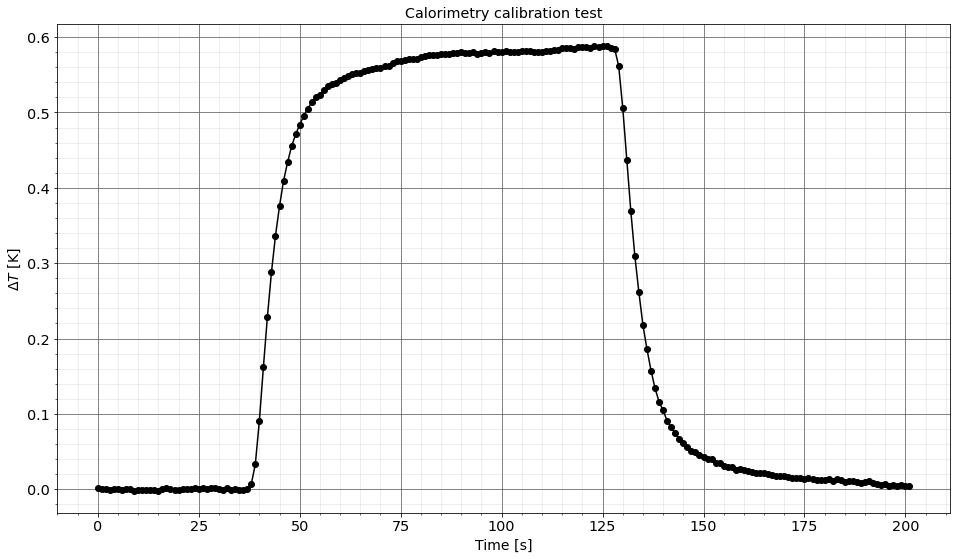

In [19]:
plot(data.t,data.Value, 'ko-')
xlabel('Time [s]', fontsize=14)
ylabel('$\Delta T$ [K]',fontsize=14)
grid(b=True, which='major', color='#666666')
minorticks_on()
grid(b=True, which='minor', color='#999999', alpha=0.2)
title('Calorimetry calibration test')
show()

In [24]:
datacal=pd.read_csv("calorimetry.csv", delimiter='|', skiprows=1)   #Import the experimental data
datacal["Date/Time"] = [datetime.strptime(x,'%Y-%m-%d %H:%M:%S.%f') for x in datacal["Date/Time"]] # converts the time strings to readable datetime
tstartcal=["2021-06-10 11:21","2021-06-10 11:44","2021-06-10 13:47","2021-06-10 14:12","2021-06-10 14:38","2021-06-10 14:53","2021-06-10 15:07"]
tstartcal= [datetime.strptime(x,'%Y-%m-%d %H:%M') for x in tstartcal] # converts the time strings to readable datetime
tendcal=[tstartcal[x]+timedelta(seconds=14*60) for x in range(len(tstartcal))] # sets the end of the experiments 20 minutes after the start

def calo(expnum):
    ind1=datacal[datacal["Date/Time"]>tstartcal[expnum-1]].index[expnum-1] #index start time
    ind2=datacal[datacal["Date/Time"]<tendcal[expnum-1]].index[-1] #index end time
    tint=datacal["Date/Time"].iloc[ind1:ind2] # Indexes of the complete experiment
    offset=datacal.Value.iloc[ind1-100:ind1].mean() # Takes the average of the 100 sec before the experiment as a base value 

    #Set expi to the values beloning to this experiment
    expi = pd.DataFrame(columns = ["time", "temp"])
    expi=expi.assign(time=datacal["Date/Time"].iloc[ind1:ind2])
    expi=expi.assign(temp=datacal.Value.iloc[ind1:ind2]-offset) 
    time_int=expi.time-expi.time.iloc[0]
    time_int2= [time_int.iloc[ii].total_seconds() for ii in range(len(time_int))] #convert time to seconds
    expi = expi.assign(t=time_int2) # assign the interval found in seconds as a column
    Tint=np.trapz(expi.temp,expi.t)
    E=mflow*(Tint*cp) #[J]
    P=E/420  # [W] divided by 7 min(the length of the experiment)

    return expi, P, Tint

In [25]:
# NEW!! CELL TO CALCULATE P FROM CALORIMETRY WITH DELTAT 
expnum=6
ind1=datacal[datacal["Date/Time"]>tstartcal[expnum-1]].index[expnum-1] #index start time
ind2=datacal[datacal["Date/Time"]<tendcal[expnum-1]].index[-1] #index end time
tint=datacal["Date/Time"].iloc[ind1:ind2] # Indexes of the complete experiment
offset=datacal.Value.iloc[ind1-100:ind1].mean() # Takes the average of the 100 sec before the experiment as a base value 

#Set expi to the values beloning to this experiment
expi = pd.DataFrame(columns = ["time", "temp"])
expi=expi.assign(time=datacal["Date/Time"].iloc[ind1:ind2])
expi=expi.assign(temp=datacal.Value.iloc[ind1:ind2]-offset) 
time_int=expi.time-expi.time.iloc[0]
time_int2= [time_int.iloc[ii].total_seconds() for ii in range(len(time_int))] #convert time to seconds
expi = expi.assign(t=time_int2) # assign the interval found in seconds as a column
Tint=np.trapz(expi.temp,expi.t)
E=mflow*(Tint*cp) #[J]
P=E/420  # [W] divided by 7 min(the length of the experiment)
# THIS IS NEW I AM TRYTING TO DETERMINE THE MAX TEMPERATURE ON THE TOP WHICH IS THE AVERAGE
# OF THE TIMES 300 TO 400
TtopFINAL=expi[expi.t<400].index[-1]
TtopSTART=expi[expi.t>300].index[0]
Tmax=expi.loc[TtopSTART:TtopFINAL].temp.mean() #<-- THIS IS NOT WORKING!!!!!!!!!!!
#P=mflow*420*(Tmax*cp)/420

Plot calorimeter data experiment 6

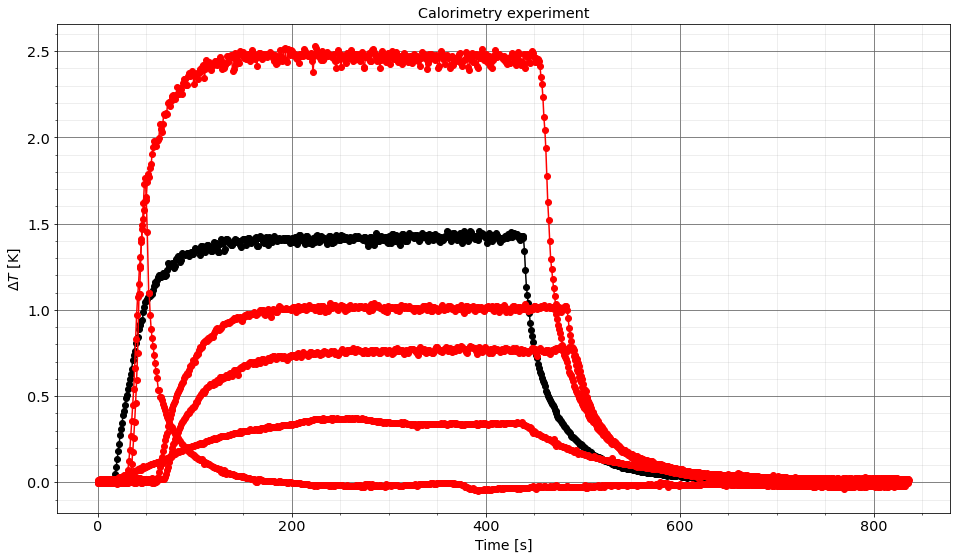

2642.9849797431516 4685.047496654973 604.1903425454 2755.887375199263 1071.008906044 4593.145625332104


In [26]:
# NEW!!
plot(calo(5)[0].t,calo(5)[0].temp, 'ko-')
plot(calo(7)[0].t,calo(7)[0].temp, 'ro-')
plot(calo(6)[0].t,calo(6)[0].temp, 'ro-')
plot(calo(4)[0].t,calo(4)[0].temp, 'ro-')
plot(calo(3)[0].t,calo(3)[0].temp, 'ro-')
plot(calo(2)[0].t,calo(2)[0].temp, 'ro-')
xlabel('Time [s]', fontsize=14)
ylabel('$\Delta T$ [K]',fontsize=14)
grid(b=True, which='major', color='#666666')
minorticks_on()
grid(b=True, which='minor', color='#999999', alpha=0.2)
title('Calorimetry experiment')
show()
# Test for (5) and (6) 
expi, P, Tint=calo(5)
expi, P2, Tint2=calo(6)
print(P,P2, Tint, mflow*420*(1.5*cp)/420, Tint2,mflow*420*(2.5*cp)/420)

Assume heat is deposited in a gaussian according to the data obtained from the Thomsons scattering, using:

\begin{equation}
    q \propto T_e^{3/2}n_e
\end{equation}

The average of the gaussian is found by averaging:

\begin{equation}
    x_{0,q}= \dfrac{x_{0,T_e}+ x_{0,n_e}}{2}
\end{equation}

neglecting the amplitude:
\begin{equation}
    T_e^{3/2}n_e=\left({e^{\dfrac{-(x-x_0)^2}{2\sigma_{Te}^2}}}\right)^{3/2} \times e^{\dfrac{-(x-x_0)^2}{2\sigma_{ne}^2}}=e^{\dfrac{-(x-x_0)^2}{2 \left(\dfrac{2\sigma_{T_e}^2\sigma_{n_e}^2}{3\sigma_{n_e}^2+2\sigma_{T_e}^2}\right) }}
\end{equation}

resulting in:

\begin{equation}
    \sigma_{q}^2= \dfrac{2\sigma_{T_e}^2\sigma_{n_e}^2}{3\sigma_{n_e}^2+2\sigma_{T_e}^2}
\end{equation} 



In [ ]:
def q(expnum): # [x]=mm, [q]=MW
    T3,popt,pcov,popt_n,pcov_n=TS(expnum)
    x0_q = (popt[1]+popt_n[1])/2
    sig_q = np.sqrt((2*popt[2]**2*popt_n[2]**2)/(2*popt[2]**2+3*popt_n[2]**2))
    expi, P=calo(expnum)
    A=P/(2*np.pi*sig_q**2)
    q=gaussian(x, A,x0_q, sig_q, 0)
    return q


In [ ]:
plot(x, q(2), 'k-',label='$B=0.6T,I=125A$')
plot(x, q(3), 'r-',label='$B=1.0T,I=125A$')
plot(x, q(4), 'b-',label='$B=1.3T,I=125A$')
plot(x, q(5), 'g-',label='$B=1.6T,I=125A$')
plot(x, q(6), 'm-',label='$B=1.6T,I=175A$')
#plot(x, q(7), 'y-',label='$B=1.6T,I=200A$')

xlabel('x [mm]', fontsize=14)
ylabel('q [MW/m^2]',fontsize=14)
grid(b=True, which='major', color='#666666')
minorticks_on()
grid(b=True, which='minor', color='#999999', alpha=0.2)
title('Heat flux deposition on the target')
legend()
#savefig('q.png', dpi=1000)
show()


Pyrometer data

In [ ]:
dataPy=pd.read_excel("Pyrometer_data_2021_06_09.xlsx")   #Import the experimental data
dataPy.time = [datetime.strptime(x,'%H:%M:%S.%f') for x in dataPy.time] # converts the time strings to readable datetime
t_diff= [(dataPy.time.diff()).iloc[x].seconds for x in range(len(dataPy))]; # determine the difference between two lines
tstartPy=dataPy[(np.array(t_diff)>120)] #when the difference is larger than 2min (120sec) the expriment has ended 
tendPy=dataPy.iloc[tstartPy.index-1]
tendPy=pd.concat([tendPy,(dataPy.iloc[len(dataPy)-1:len(dataPy)])])


In [ ]:
IRnum_empty=[0,3,12,15,18] #There is no Pyrometer data for the first two experiments
IRnum=[0,7,13,16,20,21] #There is no Pyrometer data for the first two experiments

def Pyro(expnum,Emp=0):
    if Emp ==0:
        i=IRnum[expnum-1]
    else:
        i=IRnum_empty[expnum-1]
    Exp=data.iloc[tstart.index[i]:tend.index[i+1]+1]
    time_int=data.time.iloc[tstart.index[i]:tend.index[i+1]+1]-data.time.iloc[tstart.index[i]] #find the time interval from experiment i and subtract the time at which the IR camera started measuring 
    time_int2= [time_int.iloc[ii].total_seconds() for ii in range(len(time_int))] #convert time to seconds
    Exp = Exp.assign(t=time_int2) # assign the interval found in seconds as a column
    return Exp

def IR(expnum, Emp =0):
    if Emp ==0:
        i=IRnum[expnum-1]
    else:
        i=IRnum_empty[expnum-1]
    dfIR=pd.read_csv("IR"+ str(i+3)+".txt", delimiter = "\t")   #Import the experimental data
    dfIR=dfIR.rename(columns={'(time)': 'time', "1 Mean  (°C)":'temp' })
    dfIR.time = [datetime.strptime(x,'%H:%M:%S.%f') for x in dfIR.time] # converts the time strings to readable datetime
    timeIR=dfIR.time-dfIR.time[0]
    timeIR2= [timeIR.iloc[ii].total_seconds() for ii in range(len(timeIR))] #convert time to seconds
    dfIR = dfIR.assign(t=timeIR2)
    return dfIR


In [ ]:
plot(IR(2).t,IR(2).temp, 'k*-' ,label='$B=0.6T,I=125A$')
plot(IR(3).t,IR(3).temp, 'r*-' ,label='$B=1.0T,I=125A$')
plot(IR(4).t,IR(4).temp, 'b*-' ,label='$B=1.3T,I=125A$')
plot(IR(5).t,IR(5).temp, 'g*-' ,label='$B=1.6T,I=125A$')
plot(IR(6).t,IR(6).temp, 'm*-' ,label='$B=1.6T,I=175A$')
#plot(IR(7).t,IR(7).temp, 'y*-' ,label='$B=1.6T,I=200A$')
legend()
xlabel('$time$ $[s]$') 
ylabel('$T$ $[\degree C]$')
ax.yaxis.label.set_color('black')
grid(b=True, which='major', color='#666666')
minorticks_on()
grid(b=True, which='minor', color='#999999', alpha=0.2)
title('IR')
#savefig('Ga_temp.png', dpi=1000)
show()

Sheath theory:

\begin{equation}
q_{tot}[eV]=q_{e}[eV]+q_{i}[eV]
\end{equation}

With:

\begin{equation}
\dfrac{q_{e}[eV]}{\Gamma_{i}}=2T_{e}[eV](1-R_{eE})
\end{equation}

\begin{equation}
\dfrac{q_{i}[eV]}{\Gamma_{i}}=(2.5T_{e}[eV]-V_{fl}[eV]-V_{ps}[eV])(1-R_{iE})+2T_{e}[eV](1-R_{eE})+\chi_{i}[eV]+\chi_{r}[eV](1-R_{iN})
\end{equation}

Using for the floating voltage and assuming $\delta=0$ for the secondairy electron emission and $T_e=T_i$
\begin{equation}
V_{fl}[eV]=0.5T_e[eV]ln\left(\dfrac{2\pi m_e}{m_i}\left(1+\dfrac{T_i}{T_e}\right)\left(\dfrac{1}{(1-\delta)^2}\right) \right)=0.5T_e[eV]ln\left(\dfrac{4\pi m_e}{m_i} \right)
\end{equation}

Collisionlesss approximation to calculate the pre-sheath voltage:
\begin{equation}
V_{ps}[eV]=T_e[eV]ln\left(\dfrac{n_e}{n_{se}}\right)\approx T_e[eV]ln\left(\dfrac{1}{2}\right)
\end{equation}

The particle flux can be found using:
\begin{equation}
\Gamma_i=\dfrac{(1+M^2)}{2}n_e\sqrt{(\gamma+1)\dfrac{T_{atent}T_e[eV]e}{m_i}}
\end{equation}
Where $\gamma$ is het heat capacity ration $\dfrac{c_p}{c_v}$, $M=0.5$ (Mach number of plasma at TS position) and $T_{atent}=1$ (Te attenuation factor from TS position to target,based on Jonathan's experiments, 1.0 = no attenuation.)

Now the heatflux factor can be found:

\begin{equation}
\gamma=\dfrac{q_{tot}[eV]}{Te[eV]}
\end{equation}

The heatflux is now:
\begin{equation}
q[W/m^2]=e\gamma\Gamma_{i}T_{antent}T_e[eV]
\end{equation}

qsheath=Gam*eV*Tatent*Te*gamma

<table>
  <thead>
    <tr>
      <th>Symbol</th>
      <th>Meaning</th>
      <th>Value for He</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>$R_{iE}$</td>
      <td>Reflection energy ion on electron</td>
      <td>$ \approx 0.4$</td>
    </tr>
    <tr>
      <td>$R_{eE}$</td>
      <td>Reflection energy electron on electron</td>
      <td>$ \approx 0.15$ </td>
    </tr>
    <tr>
      <td>$R_{iN}$</td>
      <td>Reflection energy ion on neutron</td>
      <td>$ \approx 0.6$ </td>
    </tr>
    <tr>
      <td>$\chi_{r}$</td>
      <td>Molecular recombination</td>
      <td>$0$</td>
    </tr>
    <tr>
      <td>$\chi_{i}$</td>
      <td>Energy deposition ions</td>
      <td>$24.6 eV$</td>
    </tr>
      
  </tbody>
</table>


In [ ]:
RiE = 0.4  #Reflection energy
ReE = 0.15  
RiN =0.6
Xr = 0.0  # energy molecular recombination
Xi = 24.6  # energy depostion by ion
delta=0

mi=4*u # mass helium ion 
gam=1.66 # heat capacity ratio 

# Assumptions 
Tatent=1 
M=0.5 # Machnumber
#NEW!!
def qsheathraw(expnum, total=0):
    T3,popt,pcov,popt_n,pcov_n=TS(expnum)
    if total==0:
        Te=T3.iloc[:,2].max()
        ne=T3.iloc[:,1].max()
        #Te=popt[0]+popt[3] #offset plus amplitude
        #ne=(popt_n[0]+popt_n[3])*1e19 #offset plus amplitude
    else:
        Te=T3.iloc[:,2]
        ne=T3.iloc[:,1]
    Ti=Te

    Vps=np.log(0.5) # Assume Collisionless 
    Vfl=0.5*Te*np.log((2*np.pi*me/mi)*(1+Ti/Te)*(1/(1-delta)**2))

    qtot=(2.5*Te-Vfl-Vps*Te)*(1-RiE)+2*Te*(1-ReE)+Xi+Xr*(1-RiN)
    gamma=qtot/Te
    Gam=(1+M**2)/2*ne*np.sqrt((gam+1)*Tatent*Te*eV/mi)
    qsheath=Gam*eV*Tatent*Te*gamma
    return qsheath*1e-6

def qsheath(expnum, total=0):
    T3,popt,pcov,popt_n,pcov_n=TS(expnum)
    if total==0:
        Te=popt[0]+popt[3] #offset plus amplitude
        ne=(popt_n[0]+popt_n[3])*1e19 #offset plus amplitude
    else:
        Te=gaussian(x, *popt)
        ne=gaussian(x, *popt_n)*1e19
    Ti=Te

    Vps=np.log(0.5) # Assume Collisionless 
    Vfl=0.5*Te*np.log((2*np.pi*me/mi)*(1+Ti/Te)*(1/(1-delta)**2))

    qtot=(2.5*Te-Vfl-Vps*Te)*(1-RiE)+2*Te*(1-ReE)+Xi+Xr*(1-RiN)
    gamma=qtot/Te
    Gam=(1+M**2)/2*ne*np.sqrt((gam+1)*Tatent*Te*eV/mi)
    qsheath=Gam*eV*Tatent*Te*gamma
    return qsheath*1e-6

In [ ]:
#NEW heat flux from TS, old method, raw data and fit to the raw data
B=['0','0',"0.6T","1T","1.3T","1.6T","1.6T"]
I=['0','0',"125A","125A","125A","125A","175A"]

for i in range(2,7):

    T3,popt,pcov,popt_n,pcov_n=TS(i)
    plot(x,qsheath(i,1),'r--',label='Fitted TS data, old method, B=' + str(B[i]) + ' I='+ str(I[i]))
    plot(T3.iloc[:,0],qsheathraw(i,1),'k*--',label='Raw TS data  B=' + str(B[i]) + ' I='+ str(I[i]))
    pop_qsheathraw, pcov = optimize.curve_fit(gaussian, T3.iloc[:,0], qsheathraw(i,1),[3,3,1,0],bounds=((0, -np.inf,0, -np.inf),(np.inf,np.inf,np.inf, np.inf))) # Optimize for temperature, popt is: [amplitude, mean, stddev,offset]
    plot(x, gaussian(x, *pop_qsheathraw),'--b',label='Fitted heat flux from black curve  B=' + str(B[i]) + ' I='+ str(I[i]))


xlabel('x [mm]', fontsize=14)
ylabel('q [MW/m^2]',fontsize=14)
grid(b=True, which='major', color='#666666')
minorticks_on()
grid(b=True, which='minor', color='#999999', alpha=0.2)
title('Heat flux deposition on the target using the sheath theory')
legend()
#xlim(1, 5)     # set the xlim to left, right
#savefig('q.png', dpi=1000)
show()

In [ ]:
#NEW Calculate power from the thomson scattering
PTS=2*np.pi*pop_qsheathraw[0]*pop_qsheathraw[2]*pop_qsheathraw[2]
expi, P=calo(5)
print(P,PTS)

In [ ]:
#NEW new q to caultulate the heat flux using calorimetry power and using the heat flux gaussian centre and sigma, blue curve
def qrawcalo(expnum): # [x]=mm, [q]=MW
    T3,popt,pcov,popt_n,pcov_n=TS(expnum)
    pop_qsheathraw, pcov = optimize.curve_fit(gaussian, T3.iloc[:,0], qsheathraw(expnum,1),[3,3,1,0],bounds=((0, -np.inf,0, -np.inf),(np.inf,np.inf,np.inf, np.inf))) # Optimize for temperature, popt is: [amplitude, mean, stddev,offset]
    x0_q = pop_qsheathraw[1]
    sig_q = pop_qsheathraw[2]
    expi, P=calo(expnum)
    A=P/(2*np.pi*sig_q**2)
    #A=pop_qsheathraw[0]
    q=gaussian(T3.iloc[:,0], A,x0_q, sig_q, 0)
    return q

In [ ]:
# NEW Heat flux from calorimetry and TS using the sheath theory shape and raw data, no fit except to the heat flux from TS to get the shape for the calorimetry
B=['0','0',"0.6T","1.0T","1.3T","1.6T","1.6T"]
I=['0','0',"125A","125A","125A","125A","175A"]
a= [None, None, None, None, None]
b= [None, None, None, None, None] 
import matplotlib.cm as cm

cmap =[ 'b','r','k','m','g']
for i in range(2,7):
    T3,popt,pcov,popt_n,pcov_n=TS(i)
    a[i-2], =plot(T3.iloc[:,0],qrawcalo(i),color = cmap[i-2],linestyle='dashed', marker='o',label='Raw TS data  B=' + str(B[i]) + ' I='+ str(I[i]))
    b[i-2], =plot(T3.iloc[:,0],qsheathraw(i,1),color = cmap[i-2],linestyle='dashed', marker='*',markersize=15,label='Raw TS data  B=' + str(B[i]) + ' I='+ str(I[i]))


##--------------------------------LEGEND ------------------------
line_columns = [
                a[0], b[0],
                (a[0], a[1]), (b[0],b[1]),
                (a[0],a[2]),  (b[0],b[2]),
                (a[0], a[3]), (b[0], b[3]),
                (a[0], a[4]), (b[0], b[4])
                ]
leg = plt.legend(line_columns, ['hh']*len(line_columns),  
             title="     B=0.6T, I=125A    B=1T, I=125A    B=1.3T, I=125A    B=1.6T, I=125A   B=1.6T, I=175A",  
             ncol=5, numpoints=1, labelcolor='w',markerfirst=False, bbox_to_anchor=(0.76, 0.75),frameon=False)
x_pos = 8+3
y_pos = 44.4
y_pos2 = 41.1
plt.text(x_pos, y_pos, "Calometry", fontsize='large').set_zorder(6)
plt.text(x_pos, y_pos2, "TS", fontsize='large').set_zorder(7)
plt.gca().add_artist(leg).set_zorder(5)
plt.gca().add_patch(
     Rectangle(
        (10.9, 38),
        29,
        13,
        edgecolor = 'k',
        facecolor = 'white',
         clip_on=False,
        fill=True
     ) ).set_zorder(4)

xlim(-25,25)
##------------------------------------LEGEND ------------------------
xlabel('x [mm]', fontsize=14)
ylabel('q [MW/m^2]',fontsize=14)
grid(b=True, which='major', color='#666666')
minorticks_on()
grid(b=True, which='minor', color='#999999', alpha=0.2)
title('Heat flux deposition on the target using the sheath theory shape and raw data')
# legend()
#savefig('q.png', dpi=1000)
plt.show()

In [ ]:
T3,popt,pcov,popt_n,pcov_n=TS(5)
# Te=popt[0]+popt[3] #offset plus amplitude
# ne=(popt_n[0]+popt_n[3])*1e19 #offset plus amplitude
# x0_q = (popt[1]+popt_n[1])/2
# sig_q = np.sqrt((2*popt[2]**2*popt_n[2]**2)/(2*popt[2]**2+3*popt_n[2]**2))

Te=gaussian(x, *popt)
ne=gaussian(x, *popt_n)
    
plot(x,qsheath(5,1), 'k--',label='Sheath theory')
plot(x,q(5),'r--',label='Calometry')
plot(x+0.5,0.25*Te**1.5*ne,'b--',label='test')

# plot(x,qsheath(6,1), 'k',label='Sheath theory')
# plot(x,q(6),'r',label='Calometry')


xlabel('x [mm]', fontsize=14)
ylabel('q [MW/m^2]',fontsize=14)
grid(b=True, which='major', color='#666666')
minorticks_on()
grid(b=True, which='minor', color='#999999', alpha=0.2)
title('Heat flux deposition on the target')
legend()
#savefig('q.png', dpi=1000)
show()

In [ ]:
qmax = np.zeros(7)
qsheathmax = np.zeros(7)
Tsat= np.zeros(7)
for i in range(2,7):
    Tsat[i]=np.mean(IR(i).temp[IR(i)[IR(i).t<20].index[-1]:IR(i)[IR(i).t<20.5].index[-1]])# mean temperature between 20s and 20.5s for exp3
    qmax[i]=np.max(q(i))
    qsheathmax[i]=np.max(qsheath(i))

    
plot(qmax,Tsat, 'k*',label='Exp, Calo')
plot(qsheathmax,Tsat, 'r*',label='Exp, TS')
plot(qmod(0.99, 8e3, 1*eV),T-273.15, 'b-',label='Model:$R=0.99$, $C=8kW/m^2K$ and $\epsilon_{cool}=1eV$')
plot(qmod(0.999, 8e3, 50*eV),T-273.15, 'g-',label='Model:$R=0.999$, $C=8kW/m^2K$ and $\epsilon_{cool}=50eV$')

xlabel('$q [MW/m^2]$')
ylabel('$T[\degree C]$')
xlim(0, 80)
legend()
ax.yaxis.label.set_color('black')
grid(b=True, which='major', color='#666666')
minorticks_on()
grid(b=True, which='minor', color='#999999', alpha=0.2)
title('Wetted gallium target')
#savefig('Wetted_Ga_qT.png', dpi=1000)
show()

In [ ]:
data=pd.read_excel("Pyrometer_data_2021_06_09.xlsx")   #Import the experimental data
data.time = [datetime.strptime(x,'%H:%M:%S.%f') for x in data.time] # converts the time strings to readable datetime
t_diff= [(data.time.diff()).iloc[x].seconds for x in range(len(data))]; # determine the difference between two lines
tstart=data[(np.array(t_diff)>120)] #when the difference is larger than 2min (120sec) the expriment has ended 
tend=data.iloc[tstart.index-1]
tend=pd.concat([tend,(data.iloc[len(data)-1:len(data)])])
tstart

def expr(i):
    dfIR=pd.read_csv("IR"+ str(i+3)+".txt", delimiter = "\t")   #Import the experimental data
    dfIR=dfIR.rename(columns={'(time)': 'time', "1 Mean  (°C)":'temp' })
    dfIR.time = [datetime.strptime(x,'%H:%M:%S.%f') for x in dfIR.time] # converts the time strings to readable datetime
    timeIR=dfIR.time-dfIR.time[0]
    timeIR2= [timeIR.iloc[ii].total_seconds() for ii in range(len(timeIR))] #convert time to seconds
    dfIR = dfIR.assign(t=timeIR2)
    Exp=data.iloc[tstart.index[i]:tend.index[i+1]+1]
    time_int=data.time.iloc[tstart.index[i]:tend.index[i+1]+1]-dfIR.time.iloc[0] #find the time interval from experiment i and subtract the time at which the IR camera started measuring 
    time_int2= [time_int.iloc[ii].total_seconds() for ii in range(len(time_int))] #convert time to seconds
    Exp = Exp.assign(t=time_int2) # assign the interval found in seconds as a column
    return Exp, dfIR

plot(expr(3)[0].t,expr(3)[0].temp, 'k*-' ,label='$B=0.6T,I=125A$')
plot(expr(3)[1].t+2,expr(3)[1].temp, 'k--' ,label='$B=0.6T,I=125A$ IR')
plot(expr(12)[0].t,expr(12)[0].temp, 'g*-' ,label='$B=1.0T,I=125A$')
plot(expr(12)[1].t+2,expr(12)[1].temp, 'g--' ,label='$B=1.0T,I=125A$ IR')
plot(expr(15)[0].t,expr(15)[0].temp, 'b*-' ,label='$B=1.3T,I=125A$')
plot(expr(15)[1].t+2.9,expr(15)[1].temp, 'b--' ,label='$B=1.3T,I=125A$ IR')
plot(expr(18)[0].t,expr(18)[0].temp, 'y*-' ,label='$B=1.6T,I=125A$')
plot(expr(18)[1].t+2.9,expr(18)[1].temp, 'y--' ,label='$B=1.6T,I=125A$ IR')
legend()
xlabel('$time$ $[s]$') 
ylabel('$T$ $[\degree C]$')
grid(b=True, which='major', color='#666666')
minorticks_on()
grid(b=True, which='minor', color='#999999', alpha=0.2)
title('Empty target')
#savefig('Ga_temp.png', dpi=1000)
show()


In [ ]:
#Emissivity=0.65

qrange= np.arange(0, 80, 0.01)
Tmelt_W=3422*np.ones(len(qrange))
Tboil_Ga=2400*np.ones(len(qrange))

kW=170 #W/mK
l=17e-3#m
eps=0.5 #porosity
qW=eps*kW*(T-Tcool)/l*1e-6

qmax = np.zeros(7)
qsheathmax = np.zeros(7)
Tsat= np.zeros(7)
Tsat_emptypyro= np.zeros(6)
Tsat_empty= np.zeros(6)

for i in range(2,7):
    if i<6:
        Tsat_emptypyro[i]=np.mean(Pyro(i,1).temp.loc[Pyro(i,1)[Pyro(i,1).t<12.2].index[-1]:Pyro(i,1)[Pyro(i,1).t<12.5].index[-1]])# mean temperature between 20s and 20.5s for exp3
        Tsat_empty[i]=np.mean(IR(i,1).temp[IR(i,1)[IR(i,1).t<20].index[-1]:IR(i,1)[IR(i,1).t<20.5].index[-1]])# mean temperature between 20s and 20.5s for exp3

    qmax[i]=np.max(q(i))
    qsheathmax[i]=np.max(qsheath(i))
    Tsat[i]=np.mean(IR(i).temp[IR(i)[IR(i).t<12.2].index[-1]:IR(i)[IR(i).t<12.5].index[-1]])# mean temperature between 20s and 20.5s for exp3

    
plot(qmax,Tsat, 'k*',label='Exp, Calo')
plot(qsheathmax,Tsat, 'r*',label='Exp, TS')
plot(qmax[0:6],Tsat_empty, 'ko',label='Exp, Calo empty target IR')
plot(qsheathmax[0:6],Tsat_empty, 'ro',label='Exp, TS empty target IR')
plot(qmax[0:6],Tsat_emptypyro, 'k<',label='Exp, Calo empty target Pyro')
plot(qsheathmax[0:6],Tsat_emptypyro, 'r<',label='Exp, TS empty target Pyro')
plot(qmod(0.99, 8e3, 1*eV),T-273.15, 'b-',label='Model:$R=0.99$, $C=8kW/m^2K$ and $\epsilon_{cool}=1eV$')
#plot(qmod(0.999, 8e3, 50*eV),T-273.15, 'g-',label='Model:$R=0.999$, $C=8kW/m^2K$ and $\epsilon_{cool}=50eV$')

plot(qrange,Tmelt_W,'g--')
plot(qrange,Tboil_Ga,'g--')
text(60, Tmelt_W[0]+50, '$T_{m,W}$', fontsize=12,color='g')
text(60, Tboil_Ga[0]+50,'$T_{b,Ga}$', fontsize=12,color='g')

plot(qW,T-273.15,'m--',label='Pure conduction in W, $\epsilon=50\%$')
xlabel('$q [MW/m^2]$')
ylabel('$T[\degree C]$')
xlim(0, 80)
legend()
ax.yaxis.label.set_color('black')
grid(b=True, which='major', color='#666666')
minorticks_on()
grid(b=True, which='minor', color='#999999', alpha=0.2)
title('Wetted gallium target')
savefig('Ga_qT.png', dpi=1000)
show()